In [1]:
import os
os.chdir('/opt/project')
print(os.getcwd())

/opt/project


In [2]:
import SimpleITK as sitk
import numpy as np
import os

%matplotlib inline
import matplotlib.pyplot as plt
from ipywidgets import interact, fixed

OUTPUT_DIR = "./outputs"

print(sitk.Version())

SimpleITK Version: 2.1.1.2 (ITK 5.2)
Compiled: Apr 11 2022 23:40:09



In [6]:
from src.dataset import ImageDataset

from src.pipeline.pipeline_components import get_data
from radiomics import imageoperations
from radiomics.imageoperations import _checkROI
from tqdm import tqdm


dataset = get_data('./data/meningioma_data', 't1ce', 'mask')


class MRIDataPreprocessor:
    def __init__(self, dataset: ImageDataset, **settings):
        self.dataset = dataset

        self._settings = settings.copy()

        self.label = settings.get('label', 1)
        self.label_channel = settings.get('label_channel', 0)
        self.interpolator = settings.get('interpolator', sitk.sitkBSpline)
        self.padDistance = settings.get('padDistance', 5)

    def load_nifti(self, image_filename, mask_filename):
        image = sitk.ReadImage(image_filename)
        mask = imageoperations.getMask(sitk.ReadImage(mask_filename), label=self.label,
                                       label_channel=self.label_channel)
        return image, mask

    def crop_to_mask(self, image, mask):
        boundingBox, correctedMask = imageoperations.checkMask(image, mask,
                                                               **self._settings)
        if correctedMask is not None:
            mask = correctedMask

        if boundingBox is None:
            raise ValueError('Mask checks failed during pre-crop')
        cropped_image, cropped_mask = imageoperations.cropToTumorMask(image, mask, boundingBox)
        return cropped_image, cropped_mask

    def resample_image_mask(self, image, mask, new_size):
        new_spacing = [curr * orig / new for curr, orig, new in
                       zip(image.GetSpacing(), image.GetSize(), new_size)]

        bb = _checkROI(image, mask, label=self.label)

        direction = np.array(mask.GetDirection())

        maskSpacing = np.array(mask.GetSpacing())
        Nd_mask = len(maskSpacing)

        spacingRatio = maskSpacing / new_spacing

        # Determine bounds of cropped volume in terms of new Index coordinate space,
        # round down for lowerbound and up for upperbound to ensure entire segmentation is captured (prevent data loss)
        # Pad with an extra .5 to prevent data loss in case of upsampling. For Ubound this is (-1 + 0.5 = -0.5)
        bbNewLBound = np.floor((bb[:Nd_mask] - 0.5) * spacingRatio - self.padDistance)

        # Ensure resampling is not performed outside bounds of original image
        bbNewLBound = np.where(bbNewLBound < 0, 0, bbNewLBound)

        bbOriginalLBound = bbNewLBound / spacingRatio
        newOriginIndex = np.array(.5 * (new_spacing - maskSpacing) / maskSpacing)
        newCroppedOriginIndex = newOriginIndex + bbOriginalLBound
        newOrigin = mask.TransformContinuousIndexToPhysicalPoint(newCroppedOriginIndex)

        imagePixelType = image.GetPixelID()
        maskPixelType = mask.GetPixelID()

        rif = sitk.ResampleImageFilter()

        rif.SetOutputSpacing(new_spacing)
        rif.SetOutputDirection(direction)
        rif.SetSize(new_size)
        rif.SetOutputOrigin(newOrigin)

        rif.SetOutputPixelType(imagePixelType)
        rif.SetInterpolator(self.interpolator)
        resampledImageNode = rif.Execute(image)

        rif.SetOutputPixelType(maskPixelType)
        rif.SetInterpolator(sitk.sitkNearestNeighbor)
        resampledMaskNode = rif.Execute(mask)

        return resampledImageNode, resampledMaskNode

    def augment_image(self, image, mask):
        # num_rotations = random.randint(0,3)
    # TODO augment images
        pass

    def preprocess(self) -> (np.ndarray, np.ndarray):
        images = []
        masks = []

        # Load images and masks, crop, resample, and convert to numpy arrays
        smallest_size = None
        for image_path, mask_path in tqdm(zip(self.dataset.image_paths, self.dataset.mask_paths),
                                          total=len(self.dataset.image_paths),
                                          desc="Processing MRI Data"):
            image, mask = self.load_nifti(image_path, mask_path)

            cropped_image, cropped_mask = self.crop_to_mask(image, mask)

            if smallest_size is None:
                smallest_size = cropped_image.GetSize()
            else:
                smallest_size = [min(s, c) for s, c in zip(smallest_size, cropped_image.GetSize())]

            images.append(cropped_image)
            masks.append(cropped_mask)

        # adjust smallest_size to be a square otherwise conv layers won't like it
        smallest_size = [min(smallest_size) for _ in range(len(smallest_size))]

        for i in tqdm(range(len(images)), desc="Resampling and Converting to Numpy"):
            resampled_image, resampled_mask = self.resample_image_mask(images[i], masks[i], smallest_size)

            assert np.equal(resampled_image.GetSize(),
                            smallest_size).all(), f"resampled image {resampled_image.GetSize()}, whereas smallest_size: {smallest_size}"

            images[i] = resampled_image
            masks[i] = resampled_mask

        return images, masks



In [7]:
data_preprocessor = MRIDataPreprocessor(dataset)
images, masks = data_preprocessor.preprocess()

Processing MRI Data: 100% 115/115 [01:30<00:00,  1.27it/s]
Resampling and Converting to Numpy: 100% 115/115 [00:00<00:00, 117.50it/s]


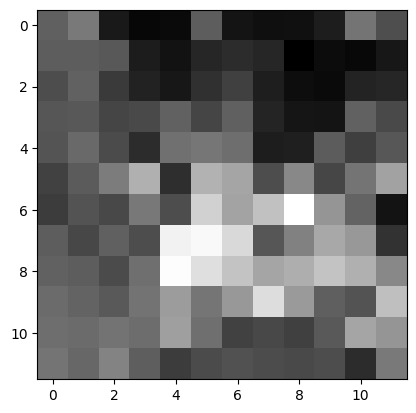

In [8]:
def plot_debug(stk_image):
    plt.figure()
    plt.imshow(sitk.GetArrayFromImage(stk_image)[5, :, :], cmap='gray')
    plt.show()

plot_debug(images[0])

In [12]:
images[0].GetSpacing()

(2.75, 3.1666666666666665, 4.083333333333333)

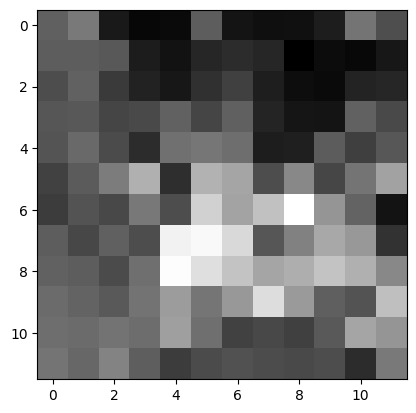

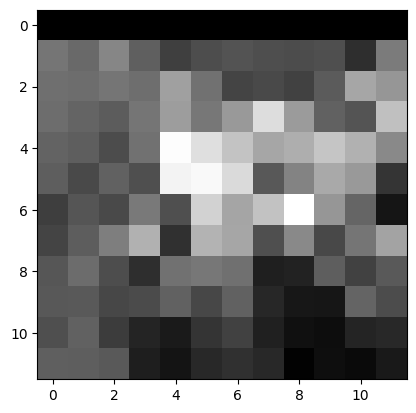

In [15]:
def flip_image(image):
    dimension = image.GetDimension()

    reference_origin = np.zeros(dimension)
    reference_size = image.GetSize()
    reference_spacing = image.GetSpacing()
    reference_direction = np.identity(dimension).flatten()

    reference_image = sitk.Image(reference_size, image.GetPixelIDValue())
    reference_image.SetOrigin(reference_origin)
    reference_image.SetSpacing(reference_spacing)
    reference_image.SetDirection(reference_direction)

    reference_center = np.array(reference_image.TransformContinuousIndexToPhysicalPoint(np.array(reference_image.GetSize())/2.0))

    transform = sitk.AffineTransform(dimension)
    transform.SetMatrix(image.GetDirection())
    transform.SetTranslation(np.array(image.GetOrigin()) - reference_origin)
    centering_transform = sitk.TranslationTransform(dimension)
    img_center = np.array(
        image.TransformContinuousIndexToPhysicalPoint(np.array(image.GetSize()) / 2.0)
    )
    centering_transform.SetOffset(
        np.array(transform.GetInverse().TransformPoint(img_center) - reference_center)
    )
    centered_transform = sitk.CompositeTransform([transform, centering_transform])

    flipped_transform = sitk.AffineTransform(dimension)
    flipped_transform.SetCenter(
        reference_image.TransformContinuousIndexToPhysicalPoint(
            np.array(reference_image.GetSize()) / 2.0
        )
    )
    if dimension == 2:  # matrices in SimpleITK specified in row major order
        flipped_transform.SetMatrix([1, 0, 0, -1])
    else:
        flipped_transform.SetMatrix([1, 0, 0, 0, -1, 0, 0, 0, 1])
    centered_transform.AddTransform(flipped_transform)

    return sitk.Resample(image, reference_image, centered_transform, sitk.sitkLinear, 0.0)

flipped_image = flip_image(images[0])

plot_debug(images[0])
plot_debug(flipped_image)

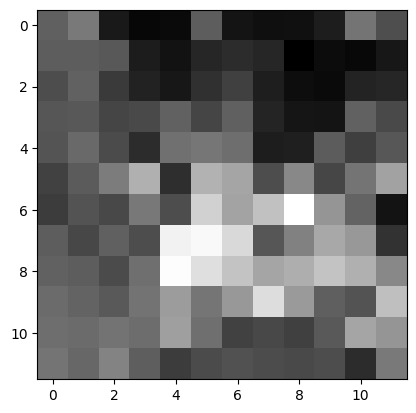

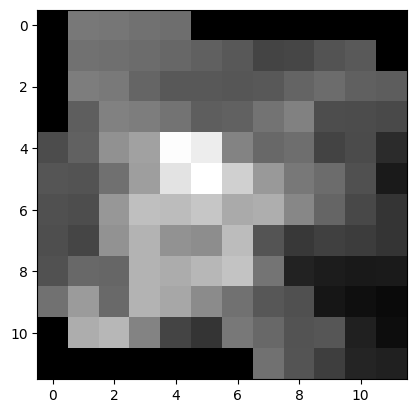

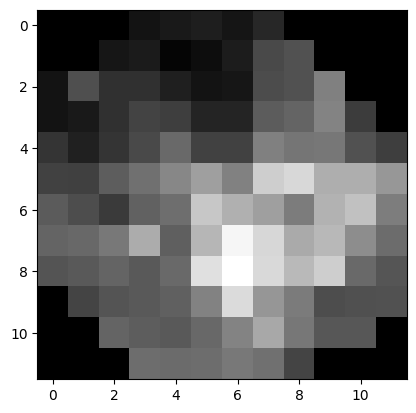

In [18]:
def eul2quat(ax, ay, az, atol=1e-8):
    """
    Translate between Euler angle (ZYX) order and quaternion representation of a rotation.
    Args:
        ax: X rotation angle in radians.
        ay: Y rotation angle in radians.
        az: Z rotation angle in radians.
        atol: tolerance used for stable quaternion computation (qs==0 within this tolerance).
    Return:
        Numpy array with three entries representing the vectoral component of the quaternion.

    """
    # Create rotation matrix using ZYX Euler angles and then compute quaternion using entries.
    cx = np.cos(ax)
    cy = np.cos(ay)
    cz = np.cos(az)
    sx = np.sin(ax)
    sy = np.sin(ay)
    sz = np.sin(az)
    r = np.zeros((3, 3))
    r[0, 0] = cz * cy
    r[0, 1] = cz * sy * sx - sz * cx
    r[0, 2] = cz * sy * cx + sz * sx

    r[1, 0] = sz * cy
    r[1, 1] = sz * sy * sx + cz * cx
    r[1, 2] = sz * sy * cx - cz * sx

    r[2, 0] = -sy
    r[2, 1] = cy * sx
    r[2, 2] = cy * cx

    # Compute quaternion:
    qs = 0.5 * np.sqrt(r[0, 0] + r[1, 1] + r[2, 2] + 1)
    qv = np.zeros(3)
    # If the scalar component of the quaternion is close to zero, we
    # compute the vector part using a numerically stable approach
    if np.isclose(qs, 0.0, atol):
        i = np.argmax([r[0, 0], r[1, 1], r[2, 2]])
        j = (i + 1) % 3
        k = (j + 1) % 3
        w = np.sqrt(r[i, i] - r[j, j] - r[k, k] + 1)
        qv[i] = 0.5 * w
        qv[j] = (r[i, j] + r[j, i]) / (2 * w)
        qv[k] = (r[i, k] + r[k, i]) / (2 * w)
    else:
        denom = 4 * qs
        qv[0] = (r[2, 1] - r[1, 2]) / denom
        qv[1] = (r[0, 2] - r[2, 0]) / denom
        qv[2] = (r[1, 0] - r[0, 1]) / denom
    return qv

def similarity3D_parameter_space_random_sampling(
    thetaX, thetaY, thetaZ, tx, ty, tz, scale, n
):
    """
    Create a list representing a random (uniform) sampling of the 3D similarity transformation parameter space. As the
    SimpleITK rotation parametrization uses the vector portion of a versor we don't have an
    intuitive way of specifying rotations. We therefor use the ZYX Euler angle parametrization and convert to
    versor.
    Args:
        thetaX, thetaY, thetaZ: Ranges of Euler angle values to use, in radians.
        tx, ty, tz: Ranges of translation values to use in mm.
        scale: Range of scale values to use.
        n: Number of samples.
    Return:
        List of lists representing the parameter space sampling (vx,vy,vz,tx,ty,tz,s).
    """
    theta_x_vals = (thetaX[1] - thetaX[0]) * np.random.random(n) + thetaX[0]
    theta_y_vals = (thetaY[1] - thetaY[0]) * np.random.random(n) + thetaY[0]
    theta_z_vals = (thetaZ[1] - thetaZ[0]) * np.random.random(n) + thetaZ[0]
    tx_vals = (tx[1] - tx[0]) * np.random.random(n) + tx[0]
    ty_vals = (ty[1] - ty[0]) * np.random.random(n) + ty[0]
    tz_vals = (tz[1] - tz[0]) * np.random.random(n) + tz[0]
    s_vals = (scale[1] - scale[0]) * np.random.random(n) + scale[0]
    res = list(
        zip(theta_x_vals, theta_y_vals, theta_z_vals, tx_vals, ty_vals, tz_vals, s_vals)
    )
    return [list(eul2quat(*(p[0:3]))) + list(p[3:7]) for p in res]

def augment_images_spatial(
    original_image,
    reference_image,
    T0,
    T_aug,
    transformation_parameters,
    interpolator=sitk.sitkLinear,
    default_intensity_value=0.0,
    additional_image_information=None,
):
    """
    Generate the resampled images based on the given transformations.
    Note: Images are written to disk with the useCompression flag
          set to true. This uses the default compression level for the user selected file
          format (via output_suffix).
    Args:
        original_image (SimpleITK image): The image which we will resample and transform.
        reference_image (SimpleITK image): The image onto which we will resample.
        T0 (SimpleITK transform): Transformation which maps points from the reference image coordinate system
            to the original_image coordinate system.
        T_aug (SimpleITK transform): Map points from the reference_image coordinate system back onto itself using the
               given transformation_parameters. The reason we use this transformation as a parameter
               is to allow the user to set its center of rotation to something other than zero.
        transformation_parameters (List of lists): parameter values which we use T_aug.SetParameters().
        output_prefix (string): output file name prefix (file name: output_prefix_p1_p2_..pn_.output_suffix).
        output_suffix (string): output file name suffix (file name: output_prefix_p1_p2_..pn_.output_suffix), also determines
                                the file formt usef for writing to disk.
        interpolator: One of the SimpleITK interpolators.
        default_intensity_value: The value to return if a point is mapped outside the original_image domain.
        additional_image_information: (Iterable([SimpleITK.Image, Interpolator, default_intensity_value])): Apply the same
                                     transformations to this set of images using the given interpolators and intensity values.
                                     The iterable cannot be a zip because that will not allow for repeated iterations.
    """
    all_images = []  # Used only for display purposes in this notebook.
    for current_parameters in transformation_parameters:
        T_aug.SetParameters(current_parameters)
        # Augmentation is done in the reference image space, so we first map the points from the reference image space
        # back onto itself T_aug (e.g. rotate the reference image) and then we map to the original image space T0.
        T_all = sitk.CompositeTransform(T0)
        T_all.AddTransform(T_aug)
        aug_image = sitk.Resample(
            original_image,
            reference_image,
            T_all,
            interpolator,
            default_intensity_value,
        )
        # Iterate over all additional images and apply the same transform to them using their specific
        # interpolator and default intensity value (e.g. for a segmentation image sitk.sitkNearestNeighbor and 0)
        if additional_image_information is not None:
            for i, (
                additional_image,
                additional_interpolator,
                additional_default_intensity_value,
            ) in enumerate(additional_image_information):
                additional_aug_image = sitk.Resample(
                    additional_image,
                    reference_image,
                    T_all,
                    additional_interpolator,
                    additional_default_intensity_value,
                )
        all_images.append(aug_image)  # Used only for display purposes in this notebook.
    return all_images  # Used only for display purposes in this notebook.


def similarity_transform3D(image, aug_transform=sitk.Similarity3DTransform()):

    dimension = image.GetDimension()
    reference_origin = np.zeros(dimension)
    reference_size = image.GetSize()
    reference_spacing = image.GetSpacing()
    reference_direction = np.identity(dimension).flatten()

    reference_image = sitk.Image(reference_size, image.GetPixelIDValue())
    reference_image.SetOrigin(reference_origin)
    reference_image.SetSpacing(reference_spacing)
    reference_image.SetDirection(reference_direction)

    reference_center = np.array(reference_image.TransformContinuousIndexToPhysicalPoint(np.array(reference_image.GetSize())/2.0))

    transform = sitk.AffineTransform(dimension)
    transform.SetMatrix(image.GetDirection())
    transform.SetTranslation(np.array(image.GetOrigin()) - reference_origin)
    # Modify the transformation to align the centers of the original and reference image instead of their origins.
    centering_transform = sitk.TranslationTransform(dimension)
    img_center = np.array(
        image.TransformContinuousIndexToPhysicalPoint(np.array(image.GetSize()) / 2.0)
    )
    centering_transform.SetOffset(
        np.array(transform.GetInverse().TransformPoint(img_center) - reference_center)
    )
    centered_transform = sitk.CompositeTransform(transform)
    centered_transform.AddTransform(centering_transform)

    # Set the augmenting transform's center so that rotation is around the image center.
    aug_transform.SetCenter(reference_center)

    transformation_parameters_list = similarity3D_parameter_space_random_sampling(
            thetaX=(0, 0),
            thetaY=(0, 0),
            thetaZ=(-np.pi / 2, np.pi / 2),
            tx=(0,0),
            ty=(0,0),
            tz=(0,0),
            scale=(1,1),
            n=2)

    generated_images = augment_images_spatial(
        image,
        reference_image,
        centered_transform,
        aug_transform,
        transformation_parameters_list,
        additional_image_information=None,
    )

    return generated_images

rotated_image = similarity_transform3D(images[0])

plot_debug(images[0])
plot_debug(rotated_image[0])
plot_debug(rotated_image[1])